# Table of Contents

1. [Single Run and Snapshot](#key1)<br>
    1.1 [Select Halos by Mass](#singlemass)<br>
    1.2 [Join Halos to Subhalos](#singlejoin)<br>
    1.3 [Connect to Binary Catalog](#binary)
2. [Single Run and Multiple Snapshots](#key2)<br>
    2.1 [Select Massive Halos in Each Snapshot](#masssnaps)<br>
    2.2 [Calculate Mass Functions in Every Snapshot](#massfns)
3. [Multiple Runs and Single Snapshot](#key3)
4. [More Complex Examples...](#key4)<br>
    4.1. [Subitem1](#sub1)<br>
    4.2. [Subitem2](#sub2)

### This notebook gives examples of how to interact with the Indra halo database tables on the SciServer.
Indra database tables contain halo and subhalo catalog information and are accessed by executing SQL queries. In many cases querying the database is much faster than reading the binary catalog files. More example queries that might be useful can be found at the [Virgo - Millennium Database](http://gavo.mpa-garching.mpg.de/Millennium/Help?page=demo/genericqueries) pages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import indratools as indra
import pandas as pd
import SciServer.CasJobs as cj

The halo and subhalo catalogs are stored in tables in the 'Indra' database context. There are two tables for each Indra run, from 2_0_0 to 7_7_7, containing FOF group or Subhalo information for every snapshot.

In [2]:
context = "Indra"
X = 2; Y = 3; Z = 4; snapnum = 58
tablename_fof = f'FOF_{X}{Y}{Z}'
tablename_sub = f'SubHalo_{X}{Y}{Z}'

Snapshot redshift and scalefactor information is also stored in a table in the Indra database. **NOTE TO SELF** 'redshift' and 'z' redundant: re-do table?

In [3]:
snaps = cj.executeQuery("select * from Snapshots order by redshift",context)
snaps.columns.values

array(['snapnum', 'redshift', 'time', 'z'], dtype=object)

In [4]:
snaps['redshift'][snaps['snapnum']==snapnum].values[0]

0.115883

There are two ways of executing SQL with the SciServer.CasJobs API: `executeQuery` and `submitJob`. **SEE DOCUMENTATION: ...** (executeQuery needs to take less than a minute, plus not have humongous output)

Selecting a full halo catalog at a low-redshift snapshot requires too much memory for the `executeQuery` command. It is better to select only what you need, or if you want to use the entire catalog (FOF + Subhalo) of one snapshot of one Indra run, load the binary catalog with `cat = indra.getsubcat((X,Y,Z),snapnum)`.

Here is a quick way to find out the column names of both tables:

In [24]:
cj.executeQuery(f'select top 1 * from {tablename_fof}',context)
#cj.executeQuery(f"select column_name from information_schema.columns where table_name = N'{tablename_fof}'",context)

,fofId,firstSubhaloId,snapnum,np,numSubs,m_mean200,r_mean200,m_crit200,r_crit200,m_tophat,r_tophat,x,y,z,phKey,vx,vy,vz
0,150390000000,150390000000000,15,23,1,140.6178,0.261417,140.6178,0.261417,140.6178,0.261417,32.63305,784.0032,203.344,40915,19.89944,144.6604,30.09615


In [9]:
cj.executeQuery(f'select top 1 * from {tablename_sub}',context)

,subhaloId,fofId,snapnum,np,x,y,z,phKey,vx,vy,vz,vDisp,vMax,spinX,spinY,spinZ,mostBoundId,halfmassRadius
0,150390000000000,150390000000,15,23,32.63305,784.0032,203.344,40915,19.89944,144.6604,30.09615,284.2457,532.5858,-0.074459,-0.418313,-0.265333,218924066,0.015765


Note that the masses are in units of 1e10 Msun/h (unlike the binary catalog), radii and positions in units of Mpc/h, and velocities in km/s. Note also that in the FOF tables, `np` refers to the number of particles in the main subhalo (e.g. `FirstSubOfHalo` given by `firstSubhaloId`) and not the parent FOF group.

# 1. Single Run and Snapshot
<a id="key1"></a>

## Select by mass
<a id="singlemass"></a>

The primary keys are `fofId` and `subhaloId` for the FOF and Subhalo tables. FOF tables are indexed on `snapnum` and `m_crit200`, and Subhalo tables on `snapnum` and `vDisp`.

Here we select halos above a given mass from a single run and snapshot. We define the minimum mass in the table's units of 1e10 Msun/h but return masses in units of Msun/h.

In [22]:
bigNumFOF = np.int(1e10)
bigNumSub = np.int(1e3)*bigNumFOF

In [5]:
minmass = 10000.  # minmass = 1e4 corresponds to 1e14 Msun/h.
sql = f"""select np, numSubs, m_crit200*1.0e10 as mass, r_crit200 as radius from {tablename_fof}
    where snapnum = {snapnum} and m_crit200 > {minmass}
    order by mass desc
"""
cj.executeQuery(sql,context)

,np,numSubs,mass,radius
0,34399,21,2.116298e+15,2.252916
1,35976,39,1.970758e+15,2.200039
2,29217,20,1.445832e+15,1.984169
3,27778,19,1.442457e+15,1.982453
4,23411,30,1.411521e+15,1.968359
...,...,...,...,...
11952,1792,1,1.000496e+14,0.814526
11953,2079,2,1.000496e+14,0.814302
11954,2229,3,1.000496e+14,0.813364
11955,2375,6,1.000496e+14,0.813073


## Select by mass and select subhalos
<a id="singlejoin"></a>

Here we again select halos above a given mass from a given run and snapshot. We also return subhalos of these halos using SQL `inner join` and the positions of the subhalos. (Note that masses are only defined for FOF groups == main subhalos). We define a new column that keeps track of whether the halo is the main subhalo of the FOF group or not, using SQL `case when` syntax.

In [6]:
minmass = 10000.  # minmass = 1e4 corresponds to 1e14 Msun/h.
sql = f"""select h.fofId, s.subhaloId, s.x, s.y, s.z, 
        case when h.firstSubhaloId = s.subhaloId then 1 else 0 end as isMain
    from {tablename_fof} h inner join {tablename_sub} s 
    on h.fofId = s.fofId
    and h.snapnum = {snapnum} and h.m_crit200 > {minmass}
"""
df = cj.executeQuery(sql,context)
df

,fofId,subhaloId,x,y,z,isMain
0,581920000036,581920000036000,488.3484,613.3842,977.52970,1
1,581920000036,581920000036001,487.7340,612.3003,976.80780,0
2,581920000036,581920000036002,486.9972,613.2515,977.05280,0
3,581920000036,581920000036003,486.9918,612.0554,976.69300,0
4,581920000041,581920000041000,469.0871,529.7056,916.95680,1
...,...,...,...,...,...,...
50627,581090000039,581090000039001,610.1967,415.3548,107.79130,0
50628,581090000039,581090000039002,610.7502,415.1198,108.01340,0
50629,581100000037,581100000037000,659.3727,342.2936,184.45990,1
50630,581100000037,581100000037001,658.2983,342.3742,184.35700,0


Let's plot them! We'll restrict the plot to a sub-volume of the full Gpc/h cube.

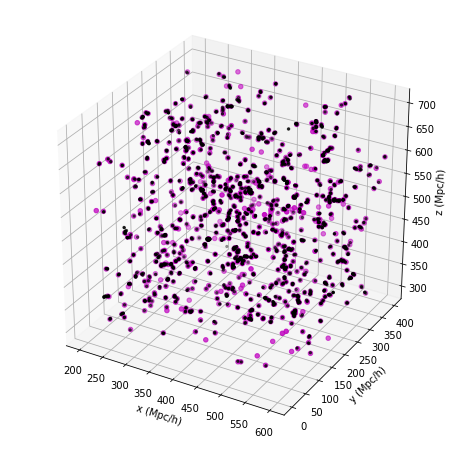

In [27]:
subdf = df[((df['x'] > 200) & (df['x'] < 600) & (df['y'] < 400) & (df['z'] > 300) & (df['z'] < 700))]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(subdf['x'][subdf['isMain']==0].values,subdf['y'][subdf['isMain']==0].values,subdf['z'][subdf['isMain']==0].values,marker='.',color='k')
ax.scatter(subdf['x'][subdf['isMain']==1].values,subdf['y'][subdf['isMain']==1].values,subdf['z'][subdf['isMain']==1].values,marker='o',color='m')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)');

## Connect DB Halos to Binary Catalog
<a id="binary"></a>

It is possible to connect the halos in the database tables to the corresponding halos as read by the binary catalog. Since all of the catalog information is already in the database tables, the main reason you might want to do this is to pick out the particles in a halo by appropriately indexing the ID arrays returned with `indra.getfofids` and `indra.getsubids`. (See `read_examples.ipynb` for how to do that.)

We'll start with the FOF groups. The database tables only contain those groups with at least one subhalo (which means the group has not been dissolved by the SUBFIND unbinding process).

In [16]:
cat = indra.getsubcat((X,Y,Z),snapnum)
hasSubs = np.where(cat['NsubPerHalo'] > 0)[0]

To relate the `fofId` values we will index a dataframe that contains all, and only, the FOF halos in this Indra run and at this `snapnum`, ordered by `fofId`.

In [17]:
fofdf = cj.executeQuery(f'select fofid, np from {tablename_fof} where snapnum={snapnum} order by fofid',context)

As an example, let's match the 4 halos containing the most particles. As noted before, `np` in the database refers to the number of particles in the main subhalo (e.g. `FirstSubOfHalo` given by `firstSubhaloId`) and not the parent FOF group, so the appropriate value in the catalog is the `subLen` of the `FirstSubOfHalo`, where `FirstSubOfHalo` is indexed by the FOF ID.

In [24]:
halos = cj.executeQuery(f"select top 4 fofid, np from {tablename_fof} where snapnum={snapnum} order by np desc",context)

In [32]:
binfofids = [hasSubs[fofdf.index[fofdf['fofid'] == halos['fofid'][i]].values[0]] for i in range(len(halos))]
binfofids

[2637425, 412448, 1620767, 2637426]

In [22]:
for i in range(len(halos)):
    print('Np from catalog = {}, Np from DB = {}'.format(cat['subLen'][cat['FirstSubOfHalo'][binfofids[i]]],fofdf['np'][fofdf['fofid']==halos['fofid'][i]].values[0]))

Np from catalog = 35976, Np from DB = 35976
Np from catalog = 34399, Np from DB = 34399
Np from catalog = 31746, Np from DB = 31746
Np from catalog = 29217, Np from DB = 29217


The subhalo tables contain all of the subhalos in the binary catalogs, so they are a bit simpler.

In [25]:
subdf = cj.executeQuery(f'select subhaloId, np from {tablename_sub} where snapnum={snapnum} order by subhaloId',context)

In [26]:
subhalos = cj.executeQuery(f"select top 4 subhaloId, np from {tablename_sub} where snapnum={snapnum} order by np desc",context)

In [33]:
binsubids = [subdf.index[subdf['subhaloId'] == subhalos['subhaloId'][i]].values[0] for i in range(len(subhalos))]
binsubids

[2685385, 419897, 1650306, 2685424]

In [34]:
for i in range(len(subhalos)):
    print('Np from catalog = {}, Np from DB = {}'.format(cat['subLen'][binsubids[i]],subdf['np'][subdf['subhaloId']==subhalos['subhaloId'][i]].values[0]))

Np from catalog = 35976, Np from DB = 35976
Np from catalog = 34399, Np from DB = 34399
Np from catalog = 31746, Np from DB = 31746
Np from catalog = 29217, Np from DB = 29217


# 2. Single Run and Multiple Snapshots
<a id="key2"></a>

## Select massive halos in each snapshot
<a id="masssnaps"></a>

In this example we'll select the most massive halo from each snapshot of a given run, while noting that the most massive halo won't necessarily be "the same" halo across snapshots.

Selecting the most massive halo in SQL uses the aggregate function `MAX` with the `GROUP BY` syntax to aggregate by `snapnum`. To select other columns that correspond to this maximum-mass halo row, use `join` on the results of the aggregating `select` clause. Note that if the two most massive halos have the same mass (unlikely but possible at early snapshots), both are returned.

In [12]:
sql = f"""select h.snapnum, h.np, h.numSubs, h.r_crit200 as radius, h.m_crit200*1.0e10 as mass,
        h.x, h.y, h.z
    from {tablename_fof} h join (select MAX(m_crit200) as mass, snapnum FROM {tablename_fof} GROUP BY snapnum) max
        on h.m_crit200 = max.mass and h.snapnum = max.snapnum
    order by h.snapnum
"""
df = cj.executeQuery(sql,context)
df[:8]

,snapnum,np,numSubs,radius,mass,x,y,z
0,15,30,1,0.265511,1.757722e+12,236.3941,112.0773,781.6100
1,16,35,1,0.323328,2.460811e+12,236.5246,112.0514,781.6426
2,17,78,1,0.381431,3.585754e+12,236.7110,112.1097,781.7067
3,18,94,1,0.453455,6.046565e+12,236.9895,112.0399,781.6568
4,19,119,1,0.503971,8.366758e+12,237.0539,111.9012,781.6778
5,20,158,1,0.534648,9.983863e+12,237.3519,112.0080,781.6508
6,21,193,1,0.574975,1.237437e+13,237.3902,111.7825,781.6188
7,22,264,1,0.614943,1.504610e+13,436.3193,381.2192,248.3477


If you want the top N most massive halos at each snapshot, use the `rank` syntax: `partition by` determines what to group on (in this case `snapnum`), and `order by` determines how to assign ranks within the group.

In [15]:
n_massive = 3 # select n_massive most massive halos
sql= f"""
    with a as(
        select fofid
        ,    rank() over(partition by snapnum order by m_crit200 desc) as rank
        from {tablename_fof})
    select h.snapnum, h.np, h.numSubs, h.r_crit200 as radius, h.m_crit200*1.0e10 as mass,
        h.x, h.y, h.z, a.rank 
    from a join {tablename_fof} h on h.fofid = a.fofid 
    where a.rank <= {n_massive}
"""
rankdf = cj.executeQuery(sql,context)
rankdf[:10]

,snapnum,np,numSubs,radius,mass,x,y,z,rank
0,47,19542,15,2.318074,1.338822e+15,229.57840,301.17080,873.21900,1
1,57,30830,21,2.163568,1.784862e+15,60.86296,776.95460,79.82032,2
2,39,7783,5,1.859413,5.129737e+14,970.20160,79.61378,282.15960,2
3,46,14790,13,2.153750,1.027072e+15,415.78410,696.23710,568.26050,3
4,56,27184,21,2.114430,1.584833e+15,149.96060,384.74900,983.94290,2
5,55,26184,26,2.205901,1.710897e+15,149.90880,384.74300,984.13800,1
6,55,25359,15,2.171155,1.631237e+15,348.45290,84.52158,898.82610,2
7,20,131,1,0.497562,9.280774e+12,105.42040,69.07778,44.89461,3
8,21,184,1,0.564665,1.181189e+13,105.26870,69.06668,44.96877,3
9,41,11658,14,2.088063,7.719213e+14,730.01050,637.35530,151.54800,1


For fun let's plot the most massive halo positions and color them by their `snapnum`.

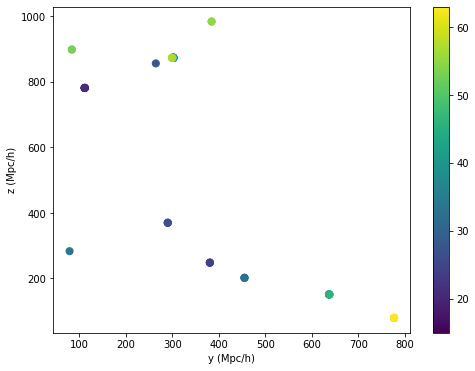

In [91]:
fig = plt.figure(figsize=(8,6))
plt.scatter(df['y'],df['z'],marker='o',s=50,c=df['snapnum'].values)
plt.colorbar()
plt.xlabel('y (Mpc/h)')
plt.ylabel('z (Mpc/h)');

## Calculate Mass Functions in Every Snapshot
<a id="massfns"></a>

You can very quickly calculate the number of halos in bins of mass in SQL by using `floor` to round down the masses and then aggregating. (This is the [Millennium DB](http://gavo.mpa-garching.mpg.de/Millennium/Help?page=demo/genericqueries) example H5). Note that if there are no halos in a given mass range in a given snapshot, this will not return a count of 0 but will simply skip it.

In [19]:
binsize = .1
sql = f"""select snapnum, power(10.0,{binsize}*floor(.5+log10(m_crit200)/{binsize}))*1e10 as mass, count(*) as num
    from {tablename_fof}
    where m_crit200 > 0
    group by  snapnum, floor(.5+log10(m_crit200)/{binsize})
    order by 1 desc, 2
"""
df = cj.executeQuery(sql,context)
df

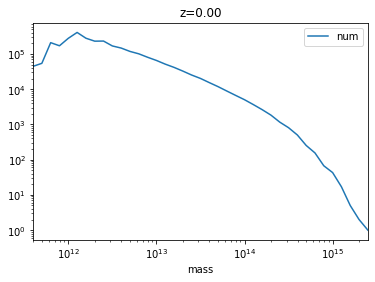

In [31]:
sn = 63
df[df['snapnum']==sn].plot(x='mass',y='num',logx=True,logy=True,title=f"z={snaps['redshift'][snaps['snapnum']==sn].values[0]:.2f}");

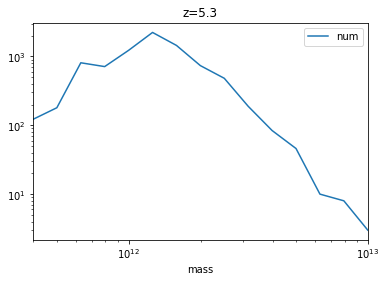

In [34]:
sn = 20
df[df['snapnum']==sn].plot(x='mass',y='num',logx=True,logy=True,title=f"z={snaps['redshift'][snaps['snapnum']==sn].values[0]:.2}");

# 3. Multiple Runs and Single Snapshot
<a id="key3"></a>

In the current schema, each Indra volume is in a separate table, and it is cumbersome to join many (hundreds of!) tables in one query. Instead, we will define a function that gets what we want from one table, then loop over that function for each desired Indra run.

In this example we will calculate histograms of mass for one snapshot and many Indra runs, then compute the average and variance of the mass functions. **TO DO: compare to reading binary catalogs**

In [4]:
def select_massfn(snapnum,table,binsize=.1,maxmass=None):
    if maxmass is None:
        sql = f"""select power(10.0,{binsize}*floor(.5+log10(m_crit200)/{binsize}))*1.0e10 as mass, count(*) as num
            from {table}
            where m_crit200 > 0 and snapnum = {snapnum}
            group by floor(.5+log10(m_crit200)/{binsize})
            order by 1
        """
    else:
        sql = f"""select power(10.0,{binsize}*floor(.5+log10(m_crit200)/{binsize}))*1.0e10 as mass, count(*) as num
            from {table}
            where m_crit200 > 0 and m_crit200 < {maxmass/1e10} and snapnum = {snapnum}
            group by floor(.5+log10(m_crit200)/{binsize})
            order by 1
        """
    return sql

In [5]:
# let's try a loop of 64. Use 3_Y_Z because 2_4_2 is missing (because of snap 59...).
# we'll limit max mass to 1e15 in hopes that this means there are no empty bins
runstart = indra.Run((3,0,0)).num
nruns = 64
boxsize=1000.
maxmass = 1.0e15

In [6]:
# how many bins will there be?
df = cj.executeQuery(select_massfn(snapnum,'FOF_300',maxmass=maxmass),context)
nbins = len(df)

In [7]:
nhalo = np.zeros((nbins,nruns),dtype=np.float32)
massfn = np.zeros((nbins,nruns),dtype=np.float32)
for i, runnum in enumerate(range(runstart,runstart+nruns)):
    run = indra.Run(runnum)
    tablename = f'FOF_{run.X}{run.Y}{run.Z}'
    df = cj.executeQuery(select_massfn(snapnum,tablename,maxmass=maxmass),context)
    nhalo[:,i] = df['num'].values
    massfn[:,i] = np.flipud(np.cumsum(np.flipud(nhalo[:,i])))/boxsize**3
    # could be more careful here and save df['mass'] too

In [8]:
mbins = df['mass'].values # the last run queried
len(df) == nbins

True

In [9]:
mfmean = np.mean(massfn,1)
mfsig = np.std(massfn,1)

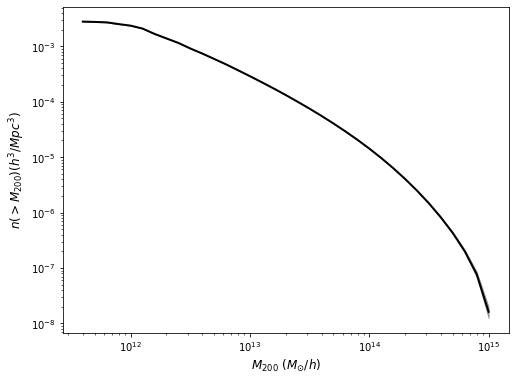

In [10]:
plt.figure(figsize=(8,6))
plt.plot(mbins,mfmean,'k',linewidth=2,label='mean')
plt.fill_between(mbins,mfmean-mfsig,mfmean+mfsig,alpha=.3,color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{200}$ ($M_{\odot}/h$)',size='large')
plt.ylabel(r'$n(>M_{200}) (h^3/Mpc^3)$',size='large');

In [14]:
nhmean = np.mean(nhalo,1)
nhsig = np.std(nhalo,1)

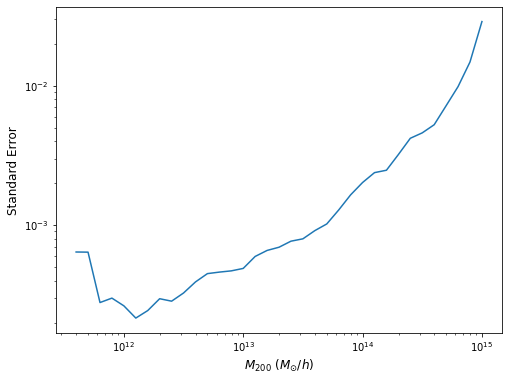

In [15]:
plt.figure(figsize=(8,6))
plt.plot(mbins,nhsig/(nhmean*np.sqrt(nruns)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{200}$ ($M_{\odot}/h$)',size='large')
plt.ylabel('Standard Error',size='large');

# More Complex Thing (like lightcone?)
<a id="key4"></a>

In [ ]:
# TO DO: copy the shape functions (etc) from SimulationDB to the Indra database
# This example would select halos in a lightcone, so wouldn't need the ParticlesInShapes functionality but could use the shape objects (if not the SQL shape functions)

For queries that take some time or return a lot of data, use `submitJob` instead of `executeQuery` and save the results to a new table in your personal `MyDB` database context. We first need to drop this table if it already exists, e.g. if you have run this example before and want to run it again.

In [ ]:
# We create a table in your MyDB below: if you do have done this already, first drop the table
temptable = f'some_name'
sql="""IF OBJECT_ID('{table}', 'U') IS NOT NULL 
  DROP TABLE {table}
""".format(table=temptable)
cj.executeQuery(sql,"MyDB")

# Now execute the query
sql = f"""select ....
    into MyDB.{temptable}
    from ....
"""
jobid = cj.submitJob(sql,context)
cj.waitForJob(jobid,verbose=True)

# Once it's done, select the results
df = cj.executeQuery(f'select * from MyDB.{temptable} order by ....')